In [1]:
import os
raw_data_dir = ''

if  'COLAB_GPU' in os.environ:
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne
    !pip install pyedflib

    print('\n \n To load files from Google Drive, account validation is required.')
    #mount to drive -- files should be located in the Colab notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
else:
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    #declare local data directory here
    raw_data_dir = '../../Data/Raw/' 


Using Google Colab. Setting up environment
     |████████████████████████████████| 6.4MB 7.5MB/s 
     |████████████████████████████████| 1.1MB 7.8MB/s 
  Created wheel for pyedflib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=920125 sha256=4d7bc750bbaf7b44118c9a1f6fd97303e65331cdbe4ca33c901c08e605b1dca8
  Stored in directory: /root/.cache/pip/wheels/57/e3/8e/ce6236e9ada08b8ff91ef922c7418dbd66f1182dfbb22f8579
Successfully built pyedflib

 
 To load files from Google Drive, account validation is required.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter yo

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

import pandas as pd
import pyedflib


import tensorflow as tf
use_gpu = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)


import numpy as np

# mne imports
import mne
from mne import io

from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint


# tools for plotting confusion matrices
from matplotlib import pyplot as plt

import random 
import math



In [3]:
#### Get all raw data

from IPython.display import Markdown, display

# edf libraries
import pyedflib
import mne

#pca dependencies
from sklearn import decomposition

ignore_list = ['s12']#['s07']  #list of patient files that should be skipped
sample_size = 20

import pyedflib
mne.set_log_level("WARNING")

# get the minimum length of the files
def get_minimum_duration(group_directory_name, patient_group_file_prefix):
    file_durations = []
    for i in range (1, 15): # reading 14 files
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        file_name = raw_data_dir + '{}/{}.edf'.format(group_directory_name, patient_id)
        f = pyedflib.EdfReader(file_name)
        file_durations.append(f.file_duration)
        f.close()
    return(min(file_durations))






    
    
def process_patient_group_all_data(group_directory_name, patient_group_file_prefix, 
                          minimum_original_duration, 
                          channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1',
                                      'F7',  'T3', 'T5', 'O1', 'F4', 'C4', 
                                      'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']):
    meta = []
    patient_id_list = []
    for i in range (1, 15): # reading 14 files
        patient_df = []
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        patient_id_list.append(patient_id)
        
        file_name = raw_data_dir + '{}/{}.edf'.format(group_directory_name, patient_id)
        data = mne.io.read_raw_edf(file_name)
        df = data.to_data_frame()
        df = df[channels]
        ## drop the first 120 seconds and last 120 seconds
        df2 = df[120: (minimum_original_duration-120)]
        if patient_id not in ignore_list:
            meta.append(np.asarray(df2))
           
                    
    return meta





#
all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
#target_channels = ['T4', 'T6', 'O2', 'T3', 'T5', 'O1',
#                   'C4', 'P4', 'C3', 'P3', 'Cz', 'Pz']

target_channels = ['Fp2', 'F8', 'T4', 'T6', 'Fp1', 'F7', 'T3', 'T5', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']

minimum_duration = min(get_minimum_duration("Healthy Controls", "h"), get_minimum_duration('SZ Patients', 's'))
print('Retrieving raw data....')
print('Minimum file duration: {} seconds'.format( minimum_duration))
print("Healthy Controls:")
hc_data_all = np.asarray(process_patient_group_all_data('Healthy Controls', 'h', minimum_duration, channels=target_channels), dtype=np.float32)
print(np.asarray(hc_data_all).shape)


print('Sz Patients:')
sz_data_all = np.asarray(process_patient_group_all_data('SZ Patients', 's', minimum_duration, channels=target_channels), dtype=np.float32)
print(np.asarray(sz_data_all).shape)




###



Retrieving raw data....
Minimum file duration: 740 seconds
Healthy Controls:
(14, 500, 17)
Sz Patients:
(13, 500, 17)


In [0]:
def select_denoised_data(patient_data):
    all_features = []
    all_entries = []
    for entry in patient_data:
        all_entries.append(entry)
        
    
    pca_denoise = decomposition.PCA(n_components=12)
    print(np.asarray(all_entries).shape)
    pca_denoise.fit(all_entries.transpose())
    denoised_data = pca_denoise.components_
    all_entries.append(np.asarray(denoised_data)) 
        
    return all_features
    

sample_size = minimum_duration #use entire window
#send all channels and all patient data; s07 is still skipped
#hc_data_all_denoised_selected = select_denoised_data(hc_data_all)
#sz_data_all_denoised_selected = select_denoised_data(sz_data_all)

#print('Shape of denoised data (extracted components) :')
#print(np.asarray(hc_data_all_denoised_selected).shape)
#print(np.asarray(sz_data_all_denoised_selected).shape)

In [0]:
#setup the network
from tensorflow.keras import layers
#https://www.tensorflow.org/guide/keras/rnn

def LSTM(samples, time_steps, nb_features, chans, nb_classes):

    model=tf.keras.Sequential()
    
    model.add(layers.LSTM(64,
                          input_shape=(chans, time_steps)
            #input_shape=(chans* nb_features, time_steps),
            ))

    model.add(Dense(8,kernel_initializer='he_uniform',activation='relu'))

    model.add(Dense(nb_classes,activation='softmax'))
    
    return model

In [6]:
#X =  np.concatenate((hc_data_all_denoised_selected, sz_data_all_denoised_selected), axis=0)
X =  np.concatenate((hc_data_all, sz_data_all), axis=0)
print('Input size: ', X.shape)
y = ([0] * len(hc_data_all)) +( [1] * len(sz_data_all))


Input size:  (27, 500, 17)


Example of Input Data From Random Patient
sz patient 09


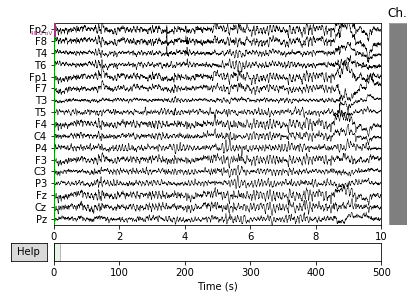

Example of Input Data From Random Control
control subject 08


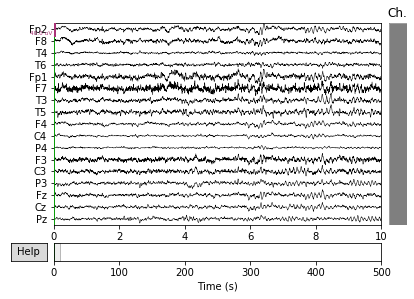

Ignored files: 
s12


In [11]:
def plot_all_channels(file_name):
    patient_id = file_name.split("\\")[-1][:-4]
    #display("### Patient ID: " +  patient_id)
    raw = mne.io.read_raw_edf(file_name, preload=True, exclude=['O1', 'O2'])
    raw.crop(tmin=120, tmax=minimum_duration-120)
    #raw.set_montage("standard_1020")
    events = mne.find_events(raw, stim_channel=raw.ch_names, initial_event=True, consecutive=True)
    raw.plot()

# plot a random patient
sz_patient_list = list(range(1, len(sz_data_all)+1, 1))
sz_patient_list.remove(12) #drop value from list of exclusions
rand_patient_id =  random.choice(sz_patient_list)
rand_patient_file=  raw_data_dir + 'SZ Patients/{}.edf'.format("{}{:02d}").format('s', rand_patient_id)

rand_control_id = random.randrange(1, len(hc_data_all)+ 1, 1)
rand_control_file = raw_data_dir + 'Healthy Controls/{}{:02d}.edf'.format('h', rand_control_id)

print('Example of Input Data From Random Patient')
print('sz patient {:02d}'.format(rand_patient_id))
plot_all_channels(rand_patient_file)

print("Example of Input Data From Random Control")
print('control subject {:02d}'.format(rand_control_id))
plot_all_channels(rand_control_file)

print('Ignored files: ')
print(",".join(ignore_list))
    
    

In [0]:
#### Create the /tmp directory if it doesn't already exist
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')

# set a valid path for the system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/LSTM_K-Fold_checkpoint.h5', verbose=1,
                               save_best_only=True)



In [19]:
#display model summary
model = LSTM(samples=samples, time_steps=time_steps, chans=chans, nb_features=1, nb_classes=2, )
model.summary()


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 64)                144640    
_________________________________________________________________
dense_76 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 18        
Total params: 145,178
Trainable params: 145,178
Non-trainable params: 0
_________________________________________________________________


In [21]:
# use sklearn wrapper to implement k-fold
from sklearn.model_selection import RepeatedKFold, cross_val_score
#from tensorflow.keras.models import * 
#from tensorflow.keras.layers import * 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


time_steps = 500 #sample_size #seconds of data to include in one slice
kernels, chans, samples = 1, len(target_channels), time_steps
X_full  = X.reshape(X.shape[0], chans, time_steps)
y_full  = np_utils.to_categorical(y, num_classes=2)


def buildmodel():
    """model= Sequential([
        Dense(10, activation="relu"),
        Dense(5, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])"""
    
    model = LSTM(samples=samples, time_steps=time_steps, chans=chans, nb_features=1, nb_classes=2, )

    #import tensorflow 
    import tensorflow.keras.optimizers
    opt_adam = tensorflow.keras.optimizers.Adam(lr=0.000001, 
                                    beta_1=0.99,
                                    beta_2=0.999,
                                    epsilon=1e-07)
    sgd = tensorflow.keras.optimizers.SGD(lr=0.01)



    def rmse (y_true, y_pred):

        return K.sqrt(K.mean(K.square(y_pred -y_true)))


    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer=opt_adam, 
                  metrics=[#'mse', 'mae', 
                      'accuracy', rmse
                     ])
    return(model)

estimator= KerasRegressor(build_fn=buildmodel, epochs=50, batch_size=16, verbose=0)
kfold= RepeatedKFold(n_splits=5, n_repeats=10)
results= cross_val_score(estimator, X_full, y_full, cv=kfold)#, n_jobs=2)  # n_jobs - number of CPUs
print('Average of R squared: ', results.mean())  # Mean MSE
print('individual values:')
results

Average of R squared:  -0.7463205635547638
individual values:


array([-0.83847433, -0.8632018 , -0.71808881, -0.67889869, -0.80185968,
       -0.7582674 , -0.79741812, -0.65465194, -0.72238243, -0.62916654,
       -0.5730294 , -0.86543125, -1.00732863, -0.63214338, -0.962376  ,
       -0.70435804, -0.64838052, -0.77955312, -0.74352717, -0.49217862,
       -0.8766368 , -0.92478687, -0.59937626, -0.66710401, -0.66909671,
       -0.76521713, -0.81278896, -1.06688952, -0.71805853, -0.59240627,
       -0.6092574 , -0.75597352, -0.6192134 , -0.60753512, -0.79410249,
       -0.50901073, -0.70607996, -0.64098889, -0.9182415 , -0.88746786,
       -0.7913329 , -1.01176357, -0.586748  , -0.9234308 , -0.91021335,
       -0.85085773, -0.58893174, -0.80284661, -0.62485081, -0.61410487])

In [0]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.12
altgraph==0.16.1
anaconda-client==1.7.2
anaconda-navigator==1.9.6
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.8.0
astroid==2.1.0
astropy==3.1
atomicwrites==1.2.1
attrs==18.2.0
Babel==2.6.0
backcall==0.1.0
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==3.0.2
blis==0.2.4
bokeh==1.0.2
boto==2.49.0
boto3==1.9.169
botocore==1.12.169
Bottleneck==1.2.1
cachetools==3.1.1
certifi==2018.11.29
cffi==1.11.5
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
clyent==1.2.2
colorama==0.4.1
colorlover==0.3.0
comtypes==1.1.7
conda==4.5.12
conda-build==3.17.6
conda-verify==3.1.1
contextlib2==0.5.5
cryptography==2.4.2
cufflinks==0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.2
cytoolz==0.9.0.1
dask==1.0.0
datashape==0.5.4
decorator==4.3.0
defusedxml==0.5.0
distributed==1.25.1
docutils==0.14
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.10
Flask==1.0.2
Flask-Cors

In [0]:
from platform import python_version

print(python_version())

3.7.1
